<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
<a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>（大規模言語モデルをスクラッチから構築）書籍の補足コード<br>
著者：<a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>コードリポジトリ：<a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第6章：テキスト分類のためのファインチューニング

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",  # Plotting library
        "numpy",       # PyTorch & TensorFlow dependency
        "tiktoken",    # Tokenizer
        "torch",       # Deep learning library
        "tensorflow",  # For OpenAI's pretrained weights
        "pandas"       # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.6.0
tensorflow version: 2.18.0
pandas version: 2.2.3


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/chapter-overview.webp" width=500px>

## 6.1 ファインチューニングの異なるカテゴリー

- このセクションにはコードはありません

- 言語モデルをファインチューニングする最も一般的な方法は、インストラクションファインチューニングと分類ファインチューニングです
- 下記に示すインストラクションファインチューニングは、次の章のトピックです

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/instructions.webp" width=500px>

- この章のトピックである分類ファインチューニングは、機械学習のバックグラウンドをお持ちの方にはおなじみかもしれません -- 例えば、手書き数字を分類するための畳み込みネットワークの訓練に似ています
- 分類ファインチューニングでは、モデルが出力できる特定数のクラスラベル（例えば、「スパム」と「スパムではない」）があります
- 分類ファインチューニングされたモデルは、訓練中に見たクラス（例えば、「スパム」または「スパムではない」）のみを予測できますが、インストラクションファインチューニングされたモデルは通常、多くのタスクを実行できます
- 分類ファインチューニングされたモデルは非常に特化したモデルと考えることができます。実際には、多くの異なるタスクでうまく機能する汎用モデルよりも、特化したモデルを作成する方がはるかに簡単です

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/spam-non-spam.webp" width=500px>

## 6.2 データセットの準備

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-1.webp" width=500px>

- このセクションでは、分類ファインチューニングに使用するデータセットを準備します
- スパムと非スパムのテキストメッセージで構成されるデータセットを使用して、LLMをファインチューニングしてそれらを分類します
- まず、データセットをダウンロードして解凍します

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


- データセットはタブ区切りのテキストファイルとして保存されており、pandas DataFrameに読み込むことができます

In [4]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- クラス分布を確認すると、データには「ham」（つまり「スパムではない」）が「spam」よりもはるかに頻繁に含まれていることがわかります

In [5]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


- 簡単のため、そして教育目的で小さなデータセットを好むため（LLMをより速くファインチューニングすることができます）、各クラスから747インスタンスが含まれるようにデータセットをサブサンプリング（アンダーサンプリング）します
- （アンダーサンプリングの他に、クラスバランスに対処する方法はいくつかありますが、LLMに関する本の範囲外です。[`imbalanced-learn`ユーザーガイド](https://imbalanced-learn.org/stable/user_guide.html)で例と詳細情報を見つけることができます）

In [6]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


- 次に、文字列クラスラベル「ham」と「spam」を整数クラスラベル0と1に変更します：

In [7]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})    

In [8]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


- それでは、データセットを訓練、検証、テストサブセットにランダムに分割する関数を定義しましょう

In [9]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 6.3 データローダーの作成

- テキストメッセージの長さが異なることに注意してください。バッチで複数の訓練例を組み合わせたい場合は、次のいずれかを行う必要があります
  1. すべてのメッセージをデータセットまたはバッチ内の最短メッセージの長さに切り詰める
  2. すべてのメッセージをデータセットまたはバッチ内の最長メッセージの長さまでパディングする

- オプション2を選択し、すべてのメッセージをデータセット内の最長メッセージまでパディングします
- そのために、第2章で説明したように、パディングトークンとして`<|endoftext|>`を使用します

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/pad-input-sequences.webp?123" width=500px>

In [10]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 以下の`SpamDataset`クラスは、訓練データセット内で最長のシーケンスを識別し、その他のシーケンスにパディングトークンを追加してそのシーケンス長に合わせます

In [ ]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # テキストを事前にトークン化
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # max_lengthより長い場合はシーケンスを切り詰める
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # 最長のシーケンスにパディング
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # 注：このメソッドを実装するよりPythonicなバージョンは
        # 次の章でも使用される以下のとおりです：
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [12]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


- 検証セットとテストセットも最長の訓練シーケンスまでパディングします
- 最長の訓練例よりも長い検証セットとテストセットのサンプルは、`SpamDataset`コード内の`encoded_text[:self.max_length]`で切り詰められることに注意してください
- この動作は完全にオプションであり、検証セットとテストセットの両方で`max_length=None`を設定してもうまく機能します

In [13]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

- 次に、データセットを使用してデータローダーをインスタンス化します。これは前の章でデータローダーを作成するのと同様です

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/batch.webp" width=500px>

In [14]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

- 検証ステップとして、データローダーを反復処理して、バッチにそれぞれ8つの訓練例が含まれ、各訓練例が120個のトークンで構成されていることを確認します

In [ ]:
print("訓練ローダー:")
for input_batch, target_batch in train_loader:
    pass

print("入力バッチの次元:", input_batch.shape)
print("ラベルバッチの次元", target_batch.shape)

- 最後に、各データセットのバッチの総数を出力しましょう

In [ ]:
print(f"{len(train_loader)} 訓練バッチ")
print(f"{len(val_loader)} 検証バッチ")
print(f"{len(test_loader)} テストバッチ")

## 6.4 事前訓練済み重みでモデルを初期化

- このセクションでは、前の章で扱った事前訓練済みモデルを初期化します

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-2.webp" width=500px>

In [17]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [18]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


- モデルが正しくロードされたことを確認するため、一貫性のあるテキストを生成するか二重チェックしましょう

In [19]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)

# Alternatively:
# from llms_from_scratch.ch05 import (
#    generate_text_simple,
#    text_to_token_ids,
#    token_ids_to_text
# )


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


- モデルを分類器としてファインチューニングする前に、モデルがおそらくすでにプロンプティングを通じてスパムメッセージを分類できるかどうか見てみましょう

In [20]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


- ご覧のとおり、モデルは指示に従うのがあまり得意ではありません
- これは、事前訓練のみが行われており、インストラクションファインチューニングが行われていないため、予想されることです（インストラクションファインチューニングは次の章で説明します）

## 6.5 分類ヘッドの追加

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/lm-head.webp" width=500px>

- このセクションでは、事前訓練済みLLMを分類ファインチューニングの準備のために変更します
- まず、モデルアーキテクチャを見てみましょう

In [21]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 上記で、第4章で実装したアーキテクチャがきれいに配置されているのが見えます
- 目標は出力層を置き換えてファインチューニングすることです
- これを達成するために、まずモデルをフリーズします。つまり、すべてのレイヤーを訓練不可能にします

In [22]:
for param in model.parameters():
    param.requires_grad = False

- 次に、元々レイヤー入力を50,257次元（語彙サイズ）にマッピングする出力層（`model.out_head`）を置き換えます
- バイナリ分類（2つのクラス、「スパム」と「スパムではない」を予測）のためにモデルをファインチューニングするため、以下に示すように出力層を置き換えることができます。これはデフォルトで訓練可能になります
- コードをより一般的に保つために、`BASE_CONFIG["emb_dim"]`（`"gpt2-small (124M)"`モデルでは768に等しい）を使用することに注意してください

In [23]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

- 技術的には、出力層のみを訓練すれば十分です
- しかし、[Finetuning Large Language Models](https://magazine.sebastianraschka.com/p/finetuning-large-language-models)で見つけたように、実験では追加のレイヤーをファインチューニングすることでパフォーマンスを著しく改善できることが示されています
- そのため、最後のトランスフォーマーブロックと、最後のトランスフォーマーブロックを出力層に接続する最終的な`LayerNorm`モジュールも訓練可能にします

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/trainable.webp" width=500px>

In [24]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

- 前の章と同様に、このモデルを引き続き使用できます
- 例えば、テキスト入力を供給してみましょう

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("入力:", inputs)
print("入力の次元:", inputs.shape) # shape: (batch_size, num_tokens)

- 前の章と異なる点は、50,257ではなく2つの出力次元を持つようになったことです

In [ ]:
with torch.no_grad():
    outputs = model(inputs)

print("出力:\n", outputs)
print("出力の次元:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

- 前の章で説明したように、各入力トークンに対して1つの出力ベクトルがあります
- モデルに4つの入力トークンを持つテキストサンプルを供給したため、出力は上記の4つの2次元出力ベクトルで構成されています

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/input-and-output.webp" width=500px>

- 第3章では、各入力トークンを他のすべての入力トークンに接続するアテンションメカニズムについて説明しました
- 第3章では、GPTのようなモデルで使用される因果アテンションマスクも紹介しました。この因果マスクにより、現在のトークンは現在および過去のトークン位置にのみアテンションを向けることができます
- この因果アテンションメカニズムに基づいて、4番目（最後）のトークンはすべてのトークンの中で最も多くの情報を含んでいます。なぜなら、他のすべてのトークンに関する情報を含む唯一のトークンだからです
- したがって、スパム分類タスクのためにファインチューニングするこの最後のトークンに特に興味があります

In [ ]:
print("最後の出力トークン:", outputs[:, -1, :])

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/attention-mask.webp" width=200px>

## 6.6 分類損失と精度の計算

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-3.webp?1" width=500px>

- 損失計算を説明する前に、モデル出力がどのようにクラスラベルに変換されるかを簡単に見てみましょう

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/class-argmax.webp" width=600px>

In [ ]:
print("最後の出力トークン:", outputs[:, -1, :])

- 第5章と同様に、`softmax`関数を介して出力（ロジット）を確率スコアに変換し、次に`argmax`関数を介して最大確率値のインデックス位置を取得します

In [ ]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("クラスラベル:", label.item())

- 第5章で説明したように、最大の出力は最大の確率スコアに対応するため、ここではsoftmax関数はオプションです

In [ ]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("クラスラベル:", label.item())

- この概念を適用して、所謂分類精度を計算できます。これは与えられたデータセット内の正しい予測の割合を計算します
- 分類精度を計算するために、前述の`argmax`ベースの予測コードをデータセット内のすべての例に適用し、次のように正しい予測の割合を計算できます：

In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # 最後の出力トークンのロジット
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

- 関数を適用して、異なるデータセットの分類精度を計算しましょう：

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 注意：
# 以下の行のコメントを外すと、該当する場合はApple Siliconチップでコードを実行できるようになります。
# これはApple CPU上よりも約2倍高速です（M3 MacBook Airで測定）。
# この記事を書いている時点で、PyTorch 2.4では、CPUとMPSを介して取得された結果は同一でした。
# ただし、PyTorchの以前のバージョンでは、MPSを使用すると異なる結果が観察される場合があります。

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#print(f"Running on {device} device.")

model.to(device) # nn.Moduleクラスではmodel = model.to(device)の割り当ては不要

torch.manual_seed(123) # 訓練データローダー内のシャッフリングによる再現性のため

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"訓練精度: {train_accuracy*100:.2f}%")
print(f"検証精度: {val_accuracy*100:.2f}%")
print(f"テスト精度: {test_accuracy*100:.2f}%")

- ご覧のとおり、予測精度はまだ良くありません。これは、モデルをまだファインチューニングしていないためです

- ファインチューニング（/訓練）を開始する前に、まず訓練中に最適化したい損失関数を定義する必要があります
- 目標はモデルのスパム分類精度を最大化することです。しかし、分類精度は微分可能な関数ではありません
- したがって、代わりに分類精度を最大化するための代理として交差エントロピー損失を最小化します（このトピックの詳細については、私の無料で利用可能な[深層学習入門](https://sebastianraschka.com/blog/2021/dl-course.html#l08-multinomial-logistic-regression--softmax-regression)クラスの講義8をご覧ください）

- `calc_loss_batch`関数は第5章と同じですが、すべてのトークン`model(input_batch)`の代わりに最後のトークン`model(input_batch)[:, -1, :]`のみを最適化することに興味があります

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # 最後の出力トークンのロジット
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

`calc_loss_loader`は第5章とまったく同じです

In [ ]:
# 第5章と同じ
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # num_batchesがデータローダー内のバッチ数を超える場合、
        # バッチ数をデータローダー内の総バッチ数に合わせて減らす
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- `calc_loss_loader`を使用して、訓練を開始する前に初期の訓練、検証、テストセットの損失を計算します

In [ ]:
with torch.no_grad(): # まだ訓練していないため、効率性のために勾配追跡を無効にする
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"訓練損失: {train_loss:.3f}")
print(f"検証損失: {val_loss:.3f}")
print(f"テスト損失: {test_loss:.3f}")

- 次のセクションでは、モデルを訓練して損失値を改善し、その結果分類精度を向上させます

## 6.7 教師ありデータでモデルをファインチューニング

- このセクションでは、モデルの分類精度を向上させるための訓練関数を定義して使用します
- 以下の`train_classifier_simple`関数は、第5章でモデルの事前訓練に使用した`train_model_simple`関数と実質的に同じです
- 唯一の2つの違いは、
  1. 見たトークン数の代わりに見た訓練例の数（`examples_seen`）を追跡するようになったこと
  2. 各エポック後にサンプルテキストを出力する代わりに精度を計算すること

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/training-loop.webp?1" width=500px>

In [ ]:
# 全体的に第5章の`train_model_simple`と同じ
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # 損失と見た例を追跡するリストを初期化
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # メイン訓練ループ
    for epoch in range(num_epochs):
        model.train()  # モデルを訓練モードに設定

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 前のバッチイテレーションからの損失勾配をリセット
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 損失勾配を計算
            optimizer.step() # 損失勾配を使用してモデルの重みを更新
            examples_seen += input_batch.shape[0] # 新規：トークンの代わりに例を追跡
            global_step += 1

            # オプションの評価ステップ
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"エポック {epoch+1} (ステップ {global_step:06d}): "
                      f"訓練損失 {train_loss:.3f}, 検証損失 {val_loss:.3f}")

        # 各エポック後に精度を計算
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"訓練精度: {train_accuracy*100:.2f}% | ", end="")
        print(f"検証精度: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

- `train_classifier_simple`で使用される`evaluate_model`関数は、第5章で使用したものと同じです

In [ ]:
# 第5章と同じ
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

- 訓練はM3 MacBook Airラップトップコンピューターで約5分、V100またはA100 GPUで30秒未満かかります

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"{execution_time_minutes:.2f}分で訓練が完了しました。")

- 第5章と同様に、matplotlibを使用して訓練セットと検証セットの損失関数をプロットします

In [ ]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # エポックに対する訓練と検証の損失をプロット
    ax1.plot(epochs_seen, train_values, label=f"訓練 {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"検証 {label}")
    ax1.set_xlabel("エポック")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # 見た例用の第2のx軸を作成
    ax2 = ax1.twiny()  # 同じy軸を共有する第2のx軸を作成
    ax2.plot(examples_seen, train_values, alpha=0)  # ティックを揃えるための見えないプロット
    ax2.set_xlabel("見た例")

    fig.tight_layout()  # レイアウトを調整してスペースを作る
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

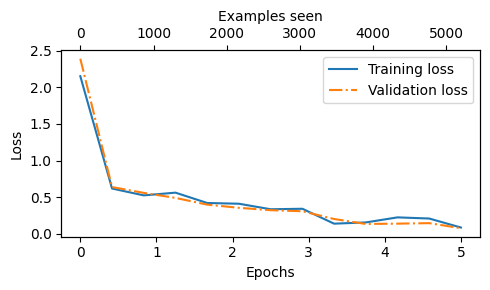

In [40]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- 上記の下向きの傾斜に基づいて、モデルがよく学習していることがわかります
- さらに、訓練損失と検証損失が非常に近いという事実は、モデルが訓練データに過学習する傾向がないことを示しています
- 同様に、以下で精度をプロットできます

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="精度")

- 上記の精度プロットに基づいて、モデルがエポック4と5の後で比較的高い訓練と検証精度を達成していることがわかります
- しかし、前に訓練関数で`eval_iter=5`を指定したことを覚えておく必要があります。これは、訓練と検証セットのパフォーマンスを推定のみしたことを意味します
- 以下のように完全なデータセットに対する訓練、検証、テストセットのパフォーマンスを計算できます

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"訓練精度: {train_accuracy*100:.2f}%")
print(f"検証精度: {val_accuracy*100:.2f}%")
print(f"テスト精度: {test_accuracy*100:.2f}%")

- 訓練セットと検証セットのパフォーマンスが実質的に同一であることがわかります
- しかし、わずかに低いテストセットパフォーマンスに基づいて、モデルが訓練データ、および学習率などのハイパーパラメータの調整に使用された検証データに対して非常に小さな程度で過学習していることがわかります
- これは正常なことであり、このギャップはモデルの`drop_rate`を増加させるか、オプティマイザー設定で`weight_decay`を増加させることで潜在的にさらに減少させることができます

## 6.8 LLMをスパム分類器として使用

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-4.webp" width=500px>

- 最後に、ファインチューニングされたGPTモデルを実際に使用しましょう
- 以下の`classify_review`関数は、前に実装した`SpamDataset`と同様のデータ前処理ステップを実装しています
- 次に、関数はモデルから予測された整数クラスラベルを返し、対応するクラス名を返します

In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # モデルへの入力を準備
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # 注意：本書では、これは元々間違ってpos_emb.weight.shape[1]として書かれていました
    # コードを壊すことはありませんでしたが、不要な切り詰め（1024ではなく768）の原因となったでしょう

    # シーケンスが長すぎる場合は切り詰める
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_lengthを指定する必要があります。完全なモデルコンテキストを使用したい場合は、"
        "max_length=model.pos_emb.weight.shape[0]を渡してください。"
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) がモデルのサポートするコンテキスト長 ({supported_context_length}) を超えています。"
    )    
    # あるいは、max_length=Noneのケースをより良く処理する、より堅牢なバージョンは以下のとおりです
    # max_len = min(max_length,supported_context_length) if max_length else supported_context_length
    # input_ids = input_ids[:max_len]
    
    # 最長のシーケンスにパディング
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # バッチ次元を追加

    # モデル推論
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # 最後の出力トークンのロジット
    predicted_label = torch.argmax(logits, dim=-1).item()

    # 分類結果を返す
    return "spam" if predicted_label == 1 else "not spam"

- 以下のいくつかの例で試してみましょう

In [44]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [45]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


- 最後に、後でモデルを再訓練することなく再利用したい場合に備えて、モデルを保存しましょう

In [46]:
torch.save(model.state_dict(), "review_classifier.pth")

- 次に、新しいセッションで、以下のようにモデルをロードできます

In [47]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## まとめと要点

- 分類ファインチューニング用の自己完結型スクリプトである[./gpt_class_finetune.py](./gpt_class_finetune.py)スクリプトをご覧ください
- 演習の解答は[./exercise-solutions.ipynb](./exercise-solutions.ipynb)で見つけることができます
- さらに、低ランク適応（LoRA）を使用したパラメータ効率的訓練の紹介に興味のある読者は、[付録E](../../appendix-E)をご覧ください